In [18]:
require(gdata)
library(caret)
library(ggplot2)
library(corrplot)
library(grid)
library(gridExtra)
library(reshape)
library(ROCR)
library(glmnet)      # For Logistic/Lasso/Ridge
library(MASS)        # For Ridge Regression
library(e1071)       # For Naive Bayes
library(rpart)       # For Decision Tree's

# Common Funcitons

In [3]:
set.seed(24287)


bindModel <- function(yLabel, xFeatures){
    # Automates the creation of feature model to be passed into an Classifier or Predictive Model  
    return (as.formula(paste(yLabel, "~", paste(xFeatures, collapse = '+ '))))
}


# Takes the complete dataframe as an input including the label column
factorToDummy_DF_Builder <- function (dataFrameIN, numericCols, factorCols, labelCol){
    # Creates a design matrix by expanding the factors to a set of dummy variables and interaction etc.
    xNumeric <- dataFrameIN[, numericCols]
    xFactor <- dataFrameIN[, c(factorCols,labelCol)]
    
    factorModel <- bindModel(yLabel=labelCol, xFeatures=factorCols)
    xFactor <- model.matrix(factorModel, data=xFactor)[, -1]        # -1 is provided to exclude the intercept term from the matrix
    yLabel <- dataFrameIN[labelCol]
    return (data.frame(xNumeric, xFactor, yLabel))
}


stratifiedSampling <- function(dataIN, sample_on_col, trainPrcnt){
  trainIndices <- createDataPartition(y=dataIN[[sample_on_col]], p=trainPrcnt, list=FALSE)
  trainData <- dataIN[trainIndices,]
  testData <- dataIN[-trainIndices,]
  
  stopifnot(nrow(trainData) + nrow(testData) == nrow(dataIN))
  return (list(trainData, testData))
}


# Plot and calculate the acuracy, specificity and sensitivity for different range of cut-offs
# For a credit default we are more interested in having a high recall or high sensitivity
performanceMetric <- function (cutoffRange, y, y_hat){
    y_bin <- y_hat
    actualYesIndex <- which(y==1)
#     perfMetric <- data.frame()
    perfMetric <- matrix(0,length(cutoffRange),3)    # 3 is because we calculate accuracy, sensitivity and specificity
    for (i in 1:length(cutoffRange)){
#         print (cutOFF)
        predYesIndex <- which(y_hat>=cutoffRange[i])
        bothYesIndex <- intersect(actualYesIndex,predYesIndex)

        # Get the Binomial prediction based on cut-off value
        y_bin[predYesIndex] <- 1
        y_bin[-predYesIndex] <- 0

        # Calculate the accuracy, specificity and sensitivity
        accuracy <- length(which(y_bin == y))/length(y)
        specificity <- length(bothYesIndex)/length(predYesIndex)
        sensitivity <- length(bothYesIndex)/length(actualYesIndex)
        cbind(accuracy, specificity, sensitivity)
        
        perfMetric[i,] <- cbind(accuracy, specificity, sensitivity)
    }
    
    return (perfMetric)
 
}

# Changing the datatypes
changeDataType <- function(dataIN, featureNames, type){
    if (type=='factor'){
        dataIN[featureNames] <- lapply(dataIN[featureNames], factor)
    }
    else if (type=='numeric'){
        dataIN[featureNames] <- lapply(dataIN[featureNames], as.numeric)
    }
    else{
        print ('No Type Specified! Specify a Type Factor or Numeric')
    }
    return (dataIN)
}

backwards <- function(fullModel, dataIN){
    
    
}

### ii. Download the credit card default data set from the UCI machine learning repository. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients Load the data into R.


In [9]:
dataDir <- "/Users/sam/All-Program/App-DataSet/Data-Science-Projects/Credit-Default/default_of_credit_card_clients.xls"
data <- read.xls (dataDir, sheet = 1, skip=1, header = TRUE)
head(data)
# data1<-read.xls(file="default_of_credit_card_clients.xlsx", sheet = 1, skip = 1, header = TRUE)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [10]:
# Remove the ID column:
credit.data <- subset(data, select=-c(ID))
head(credit.data)
dim(credit.data)

# Change the label column name
colnames(credit.data)[24] <- "default"

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
20000,2,2,1,24,2,2,-1,-1,-2,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,-1,2,0,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,0,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,0,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,-1,0,-1,0,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,0,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


[1] 30000    24

### iii. Identify all the relevant categorical, numeric, and logical variables.

It seems that [sex, education, marriage, age], [PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6] are nominal

There's is only one logical variable "default" as it can take only two value either "Yes (True)" or "No (False)"

PAY_0 : September,
PAY_2 : August
PAY_3 : July
PAY_4 : June
PAY_5 : May
PAY_6 : April
 -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 

In [11]:
uniqueCount <- function (feature){
    return (length(unlist(unique(credit.data[feature]))))
  } 
sapply(colnames(credit.data), FUN=uniqueCount)

LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
       81         2         7         4        56        11        11        11 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
       11        10        10     22723     22346     22026     21548     21010 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6   default 
    20604      7943      7899      7518      6937      6897      6939         2

In [12]:
numericCols <- names(which(sapply(credit.data, is.numeric)))
nominalCols <- names(which(sapply(credit.data, is.factor)))
print (nrow(credit.data))
print (ncol(credit.data))

# Convert into Proper datatypes
credit.nominalCols <- c('SEX','EDUCATION','MARRIAGE')
credit.numericCols <- setdiff(colnames(credit.data), credit.nominalCols)
credit.data <- changeDataType(credit.data, credit.nominalCols, type='factor')
credit.data <- changeDataType(credit.data, credit.numericCols, type='numeric')


# CAPTURE Numeric and nominal and the label Columns
credit.labelCol <- 'default'
credit.numericCols <- setdiff(names(which(sapply(credit.data, is.numeric))), credit.labelCol)
credit.nominalCols <- names(which(sapply(credit.data, is.factor)))

str(credit.data)
credit.labelCol
credit.numericCols
credit.nominalCols

# # Check if data is missing
# which(is.na(credit.data))

[1] 30000
[1] 24
'data.frame':	30000 obs. of  24 variables:
 $ LIMIT_BAL: num  20000 120000 90000 50000 50000 50000 500000 100000 140000 20000 ...
 $ SEX      : Factor w/ 2 levels "1","2": 2 2 2 2 1 1 1 2 2 1 ...
 $ EDUCATION: Factor w/ 7 levels "0","1","2","3",..: 3 3 3 3 3 2 2 3 4 4 ...
 $ MARRIAGE : Factor w/ 4 levels "0","1","2","3": 2 3 3 2 2 3 3 3 2 3 ...
 $ AGE      : num  24 26 34 37 57 37 29 23 28 35 ...
 $ PAY_0    : num  2 -1 0 0 -1 0 0 0 0 -2 ...
 $ PAY_2    : num  2 2 0 0 0 0 0 -1 0 -2 ...
 $ PAY_3    : num  -1 0 0 0 -1 0 0 -1 2 -2 ...
 $ PAY_4    : num  -1 0 0 0 0 0 0 0 0 -2 ...
 $ PAY_5    : num  -2 0 0 0 0 0 0 0 0 -1 ...
 $ PAY_6    : num  -2 2 0 0 0 0 0 -1 0 -1 ...
 $ BILL_AMT1: num  3913 2682 29239 46990 8617 ...
 $ BILL_AMT2: num  3102 1725 14027 48233 5670 ...
 $ BILL_AMT3: num  689 2682 13559 49291 35835 ...
 $ BILL_AMT4: num  0 3272 14331 28314 20940 ...
 $ BILL_AMT5: num  0 3455 14948 28959 19146 ...
 $ BILL_AMT6: num  0 3261 15549 29547 19131 ...
 $ PAY_AMT1 : n

[1] "default"

[1] "LIMIT_BAL" "AGE"       "PAY_0"     "PAY_2"     "PAY_3"     "PAY_4"    
 [7] "PAY_5"     "PAY_6"     "BILL_AMT1" "BILL_AMT2" "BILL_AMT3" "BILL_AMT4"
[13] "BILL_AMT5" "BILL_AMT6" "PAY_AMT1"  "PAY_AMT2"  "PAY_AMT3"  "PAY_AMT4" 
[19] "PAY_AMT5"  "PAY_AMT6"

[1] "SEX"       "EDUCATION" "MARRIAGE"

### iv. Perform all required EDA on this data set.

In [8]:
# ScatterPlot
# We select a small sample to plot
# plot(credit.data)

set.seed(24287)
samplePrcntg <- 0.10
credit.sampleIndices <- createDataPartition(y = credit.data$default, p=samplePrcntg, list=FALSE)
credit.sample <- credit.data[credit.sampleIndices , ]

head(credit.sample)
nrow(credit.sample)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
9,140000,2,3,1,28,0,0,2,0,0,⋯,12211,11793,3719,3329,0,432,1000,1000,1000,0
16,50000,2,3,3,23,1,2,0,0,0,⋯,28771,29531,30211,0,1500,1100,1200,1300,1100,0
24,450000,2,1,1,40,-2,-2,-2,-2,-2,⋯,560,0,0,19428,1473,560,0,0,1128,1
26,50000,1,3,2,23,0,0,0,0,0,⋯,28967,29829,30046,1973,1426,1001,1432,1062,997,0
27,60000,1,1,2,27,1,-2,-1,-1,-1,⋯,-57,127,-189,0,1000,0,500,0,1000,1
42,70000,2,1,2,25,0,0,0,0,0,⋯,63699,64718,65970,3000,4500,4042,2500,2800,2500,0


[1] 3000

--> Correlation Matrix

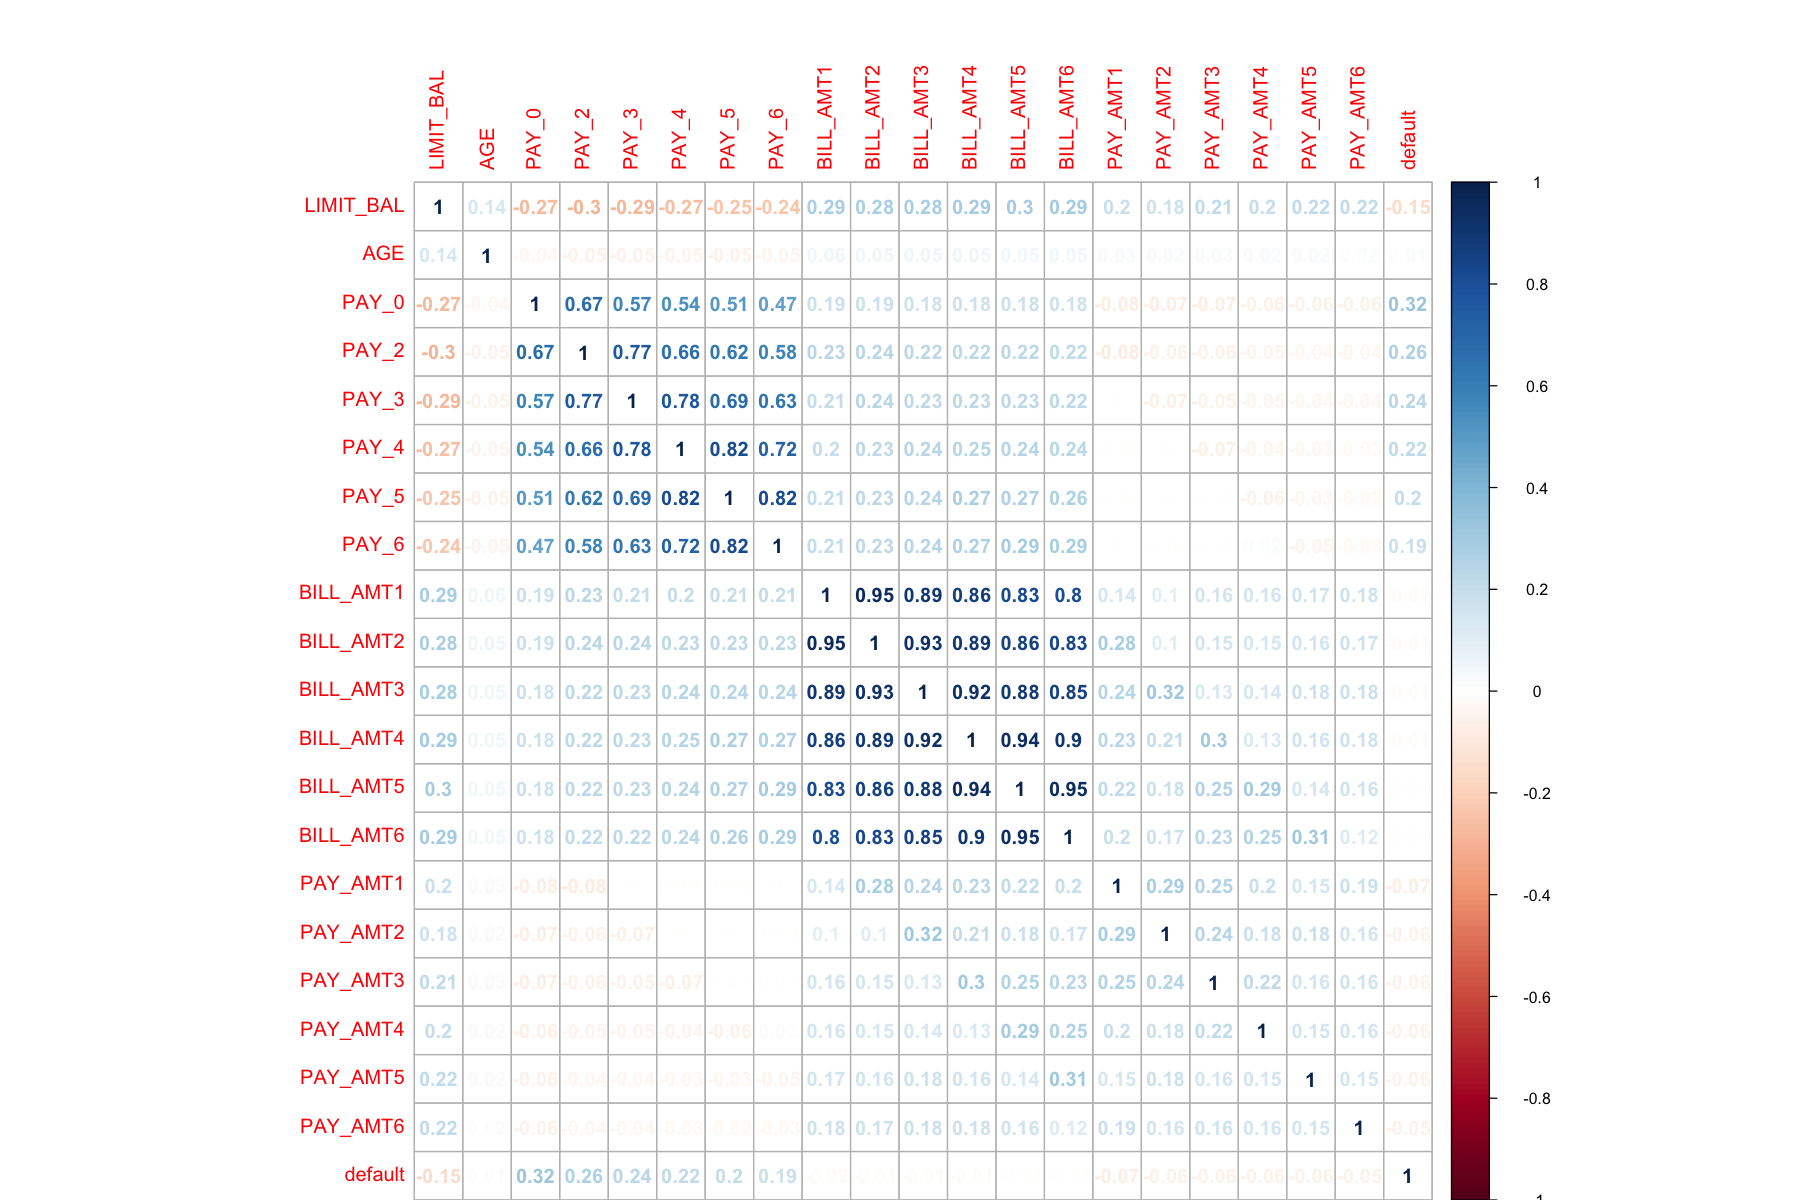

In [22]:
options(repr.plot.width=15, repr.plot.height=10)
credit.cor_matrix <- cor(credit.data[, c(credit.numericCols, credit.labelCol)])         # Building the correlation plot
corrplot(credit.cor_matrix, method="number") 

--> Scatter Plot

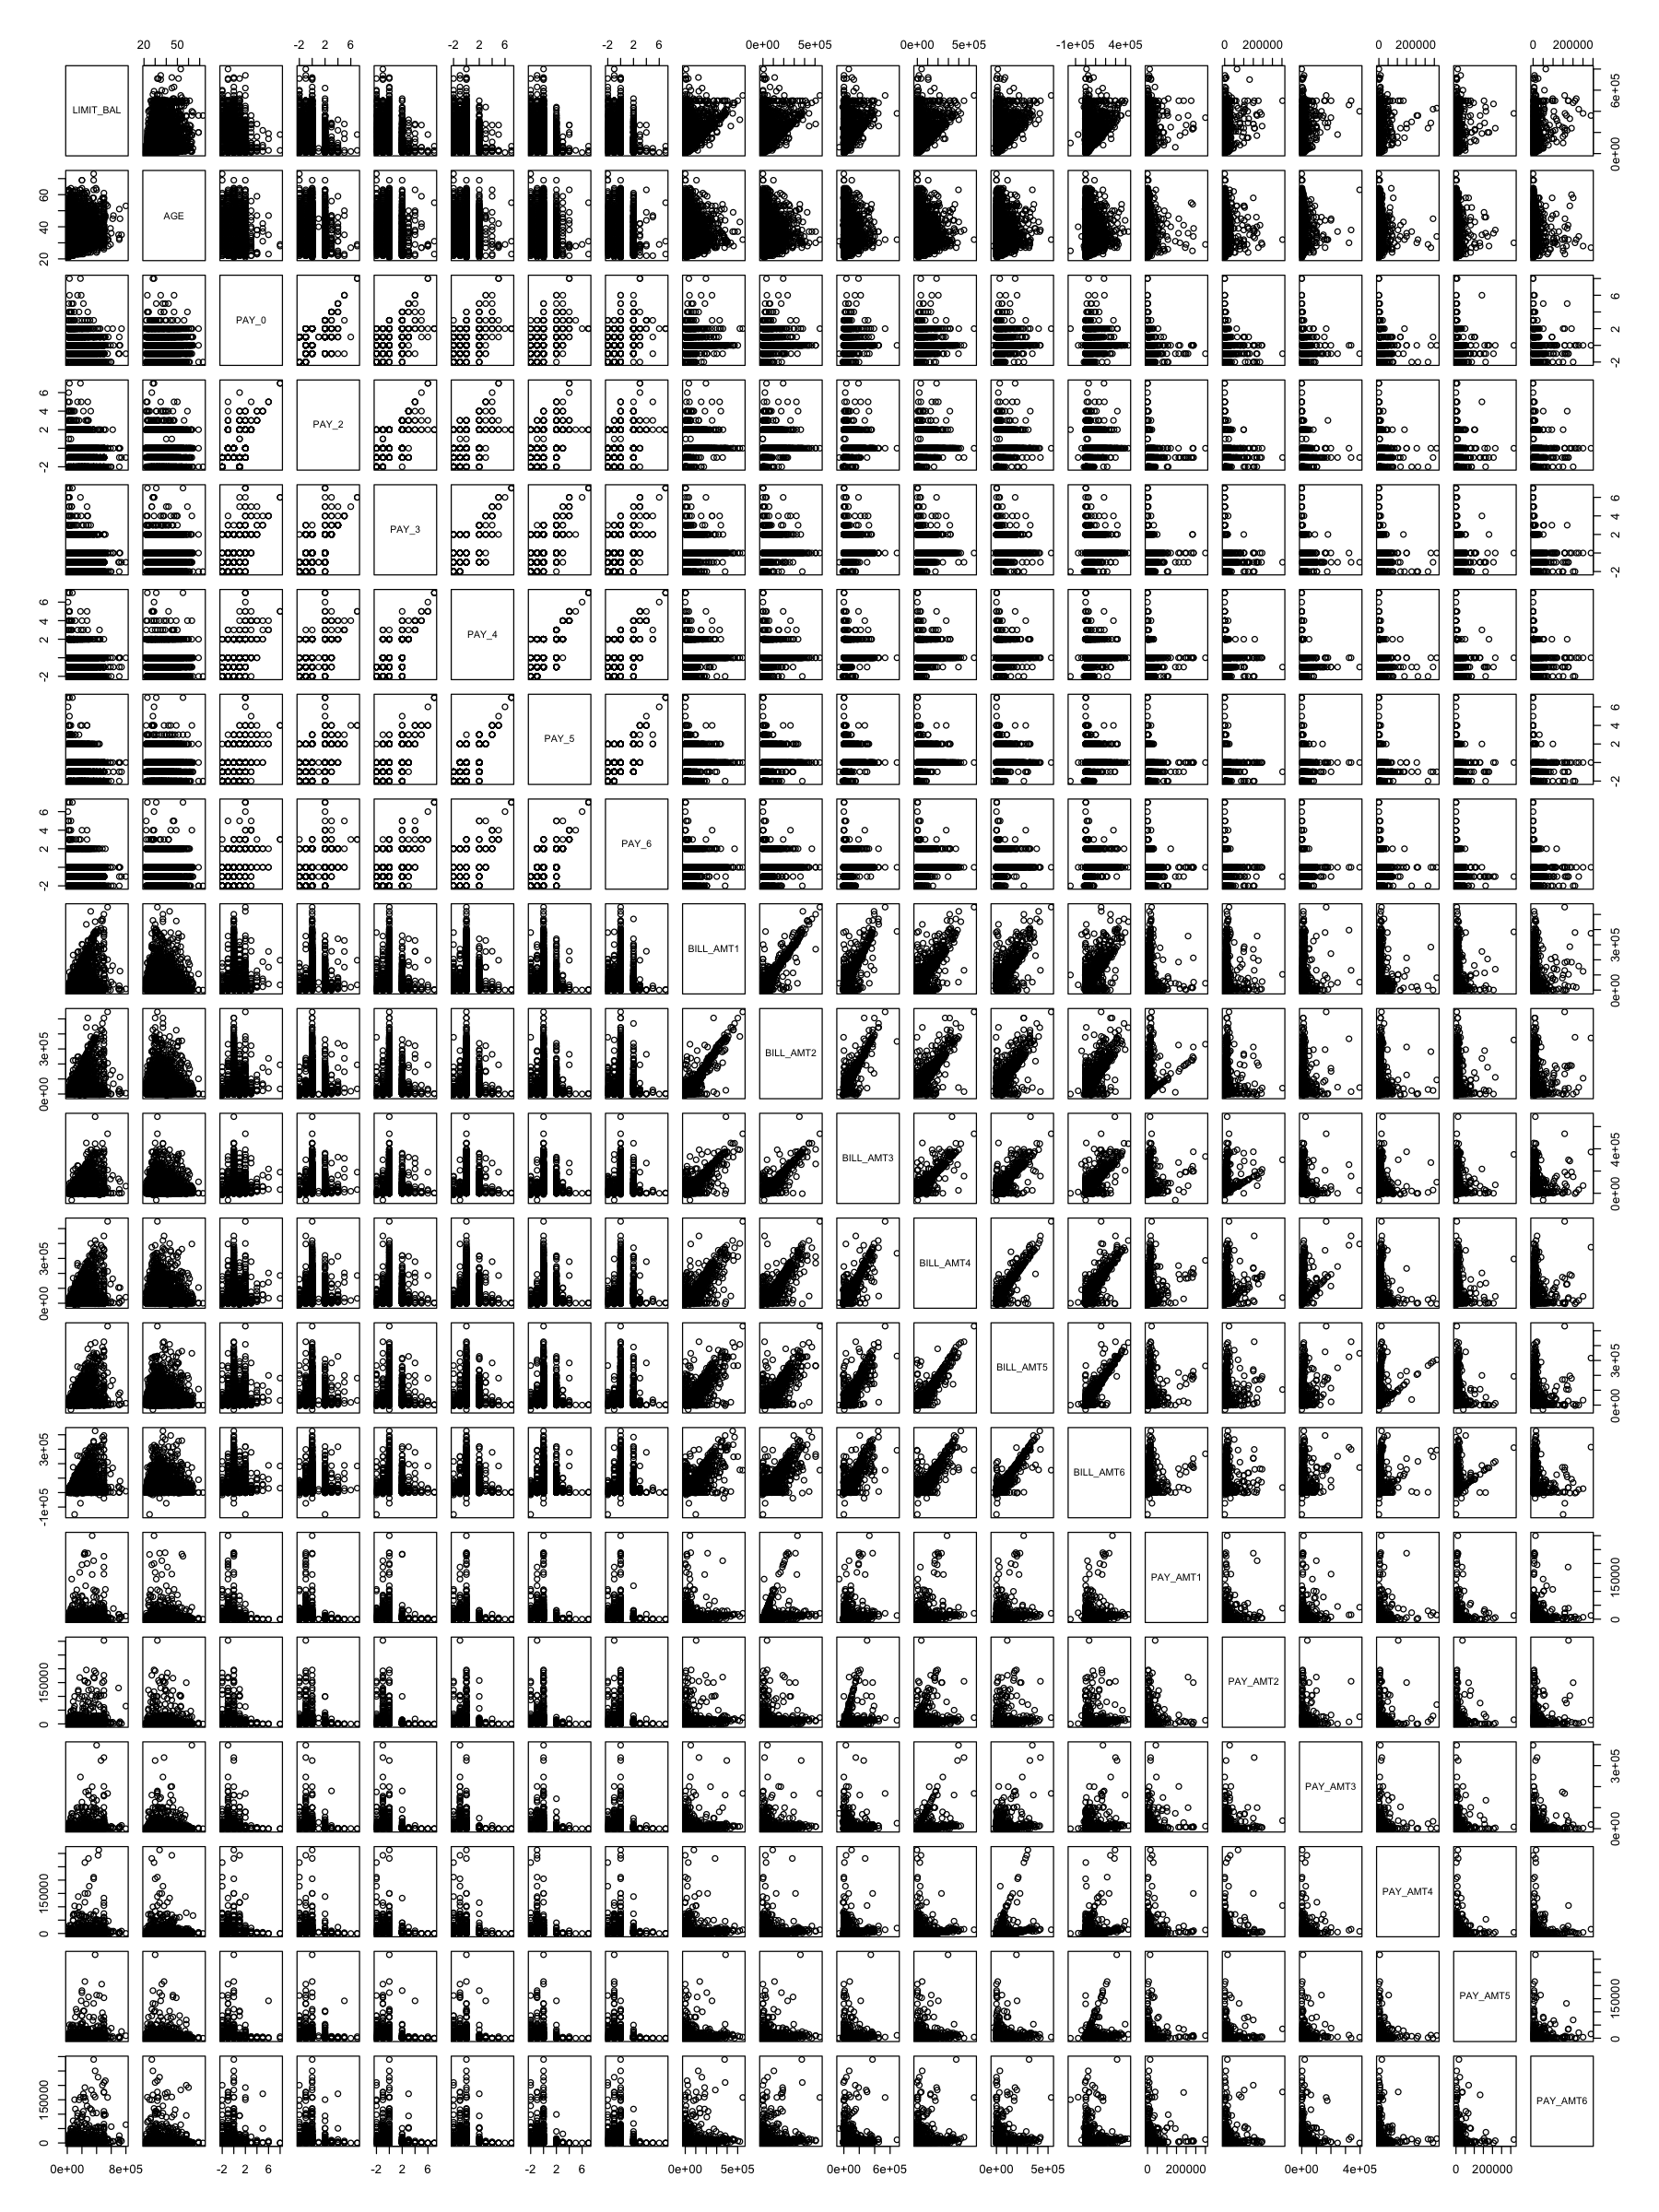

In [9]:
options(repr.plot.width=15, repr.plot.height=20)
plot(credit.sample[, credit.numericCols])

--> Box Plots:

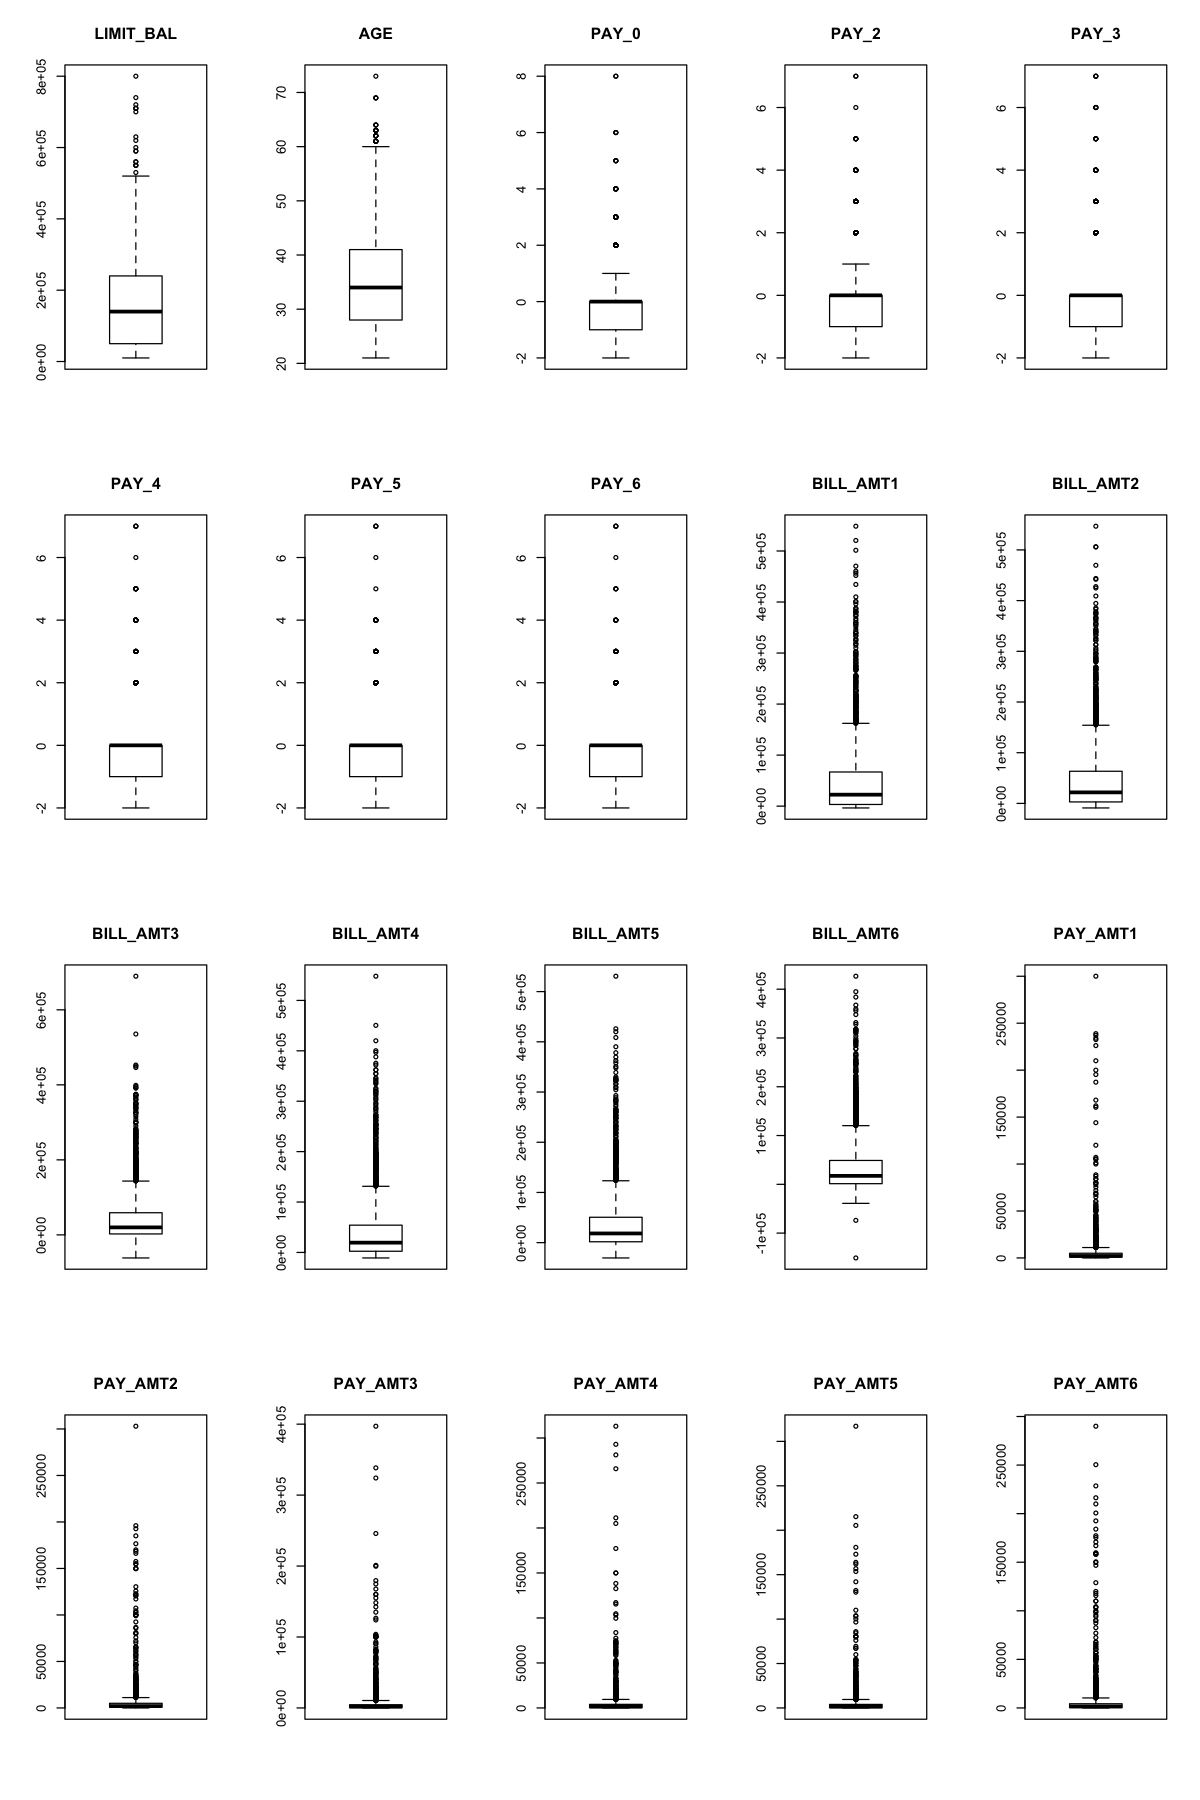

In [10]:
# dev.off()
options(repr.plot.width=10, repr.plot.height=15)
par(mfrow=c(4,5))
crearteBoxPlots <- function (column_name, dataIN){
#     print (column_name)
#     print (nrow(dataIN))
    boxplot(dataIN[column_name], horizontal = FALSE,  main= column_name)
#     stripchart(dataIN[column_name], add = TRUE, pch = 20, col = 'red')
} 
a <- sapply(credit.numericCols, FUN=crearteBoxPlots, dataIN=credit.sample)

--> Histograms for Numerical columns:

Using  as id variables


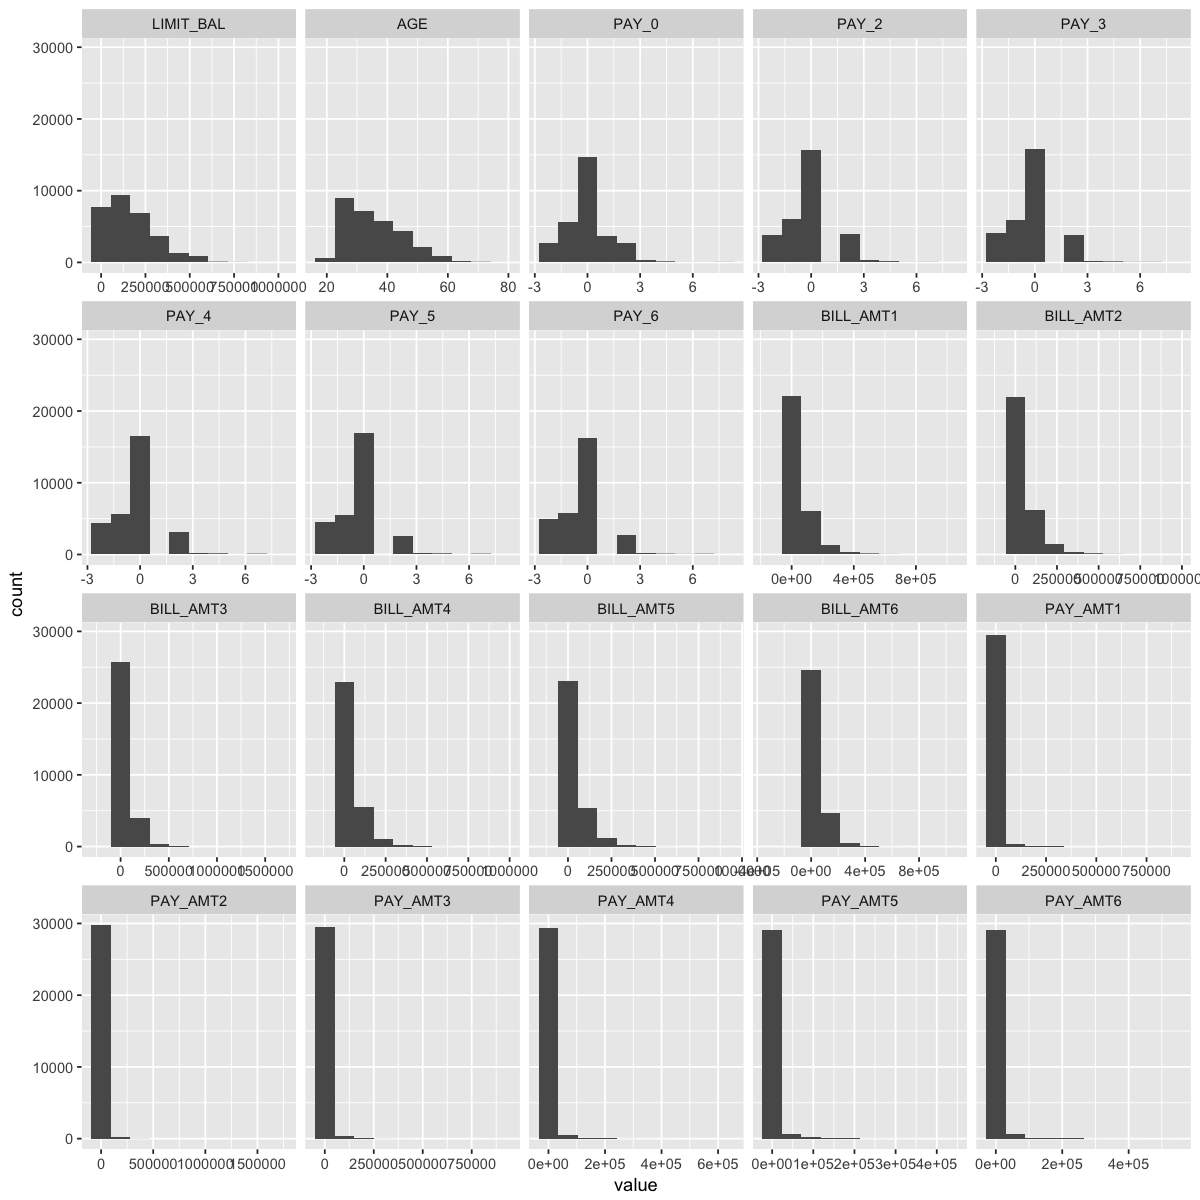

In [11]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data = melt(credit.data[, credit.numericCols]), mapping = aes(x = value)) + 
        geom_histogram(bins = 10) + facet_wrap(~variable, scales = 'free_x')

--> Bar plots for Nominal attributes

0.7
1.9
0.7
1.9
3.1
4.3
5.5
6.7
7.9
0.7
1.9


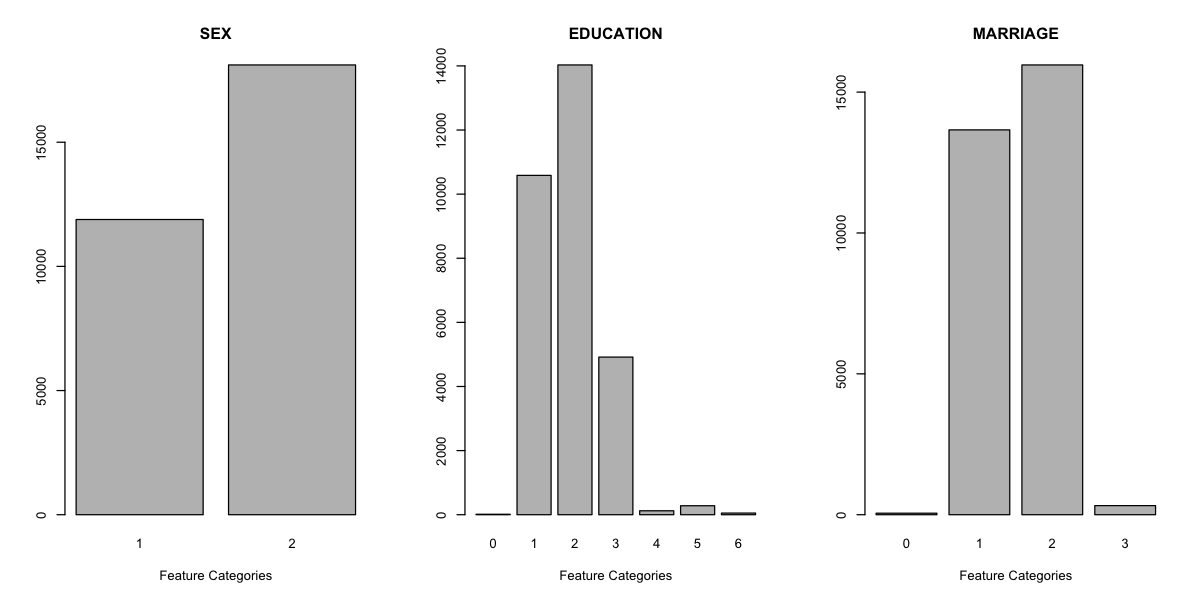

In [51]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,3))
barPlots <- function(featureVector, dataIN){
    tab <- table(dataIN[featureVector])
#     print (tab)
    barplot(tab, main=featureVector, xlab="Feature Categories")
}
sapply(credit.nominalCols, FUN=barPlots, credit.data)

--> Bar plots of Nominal attributes and class Labels

1.5,4.5
2.5,5.5
1.5,9.5
2.5,10.5
3.5,11.5
4.5,12.5
5.5,13.5
6.5,14.5
7.5,15.5
1.5,6.5
2.5,7.5


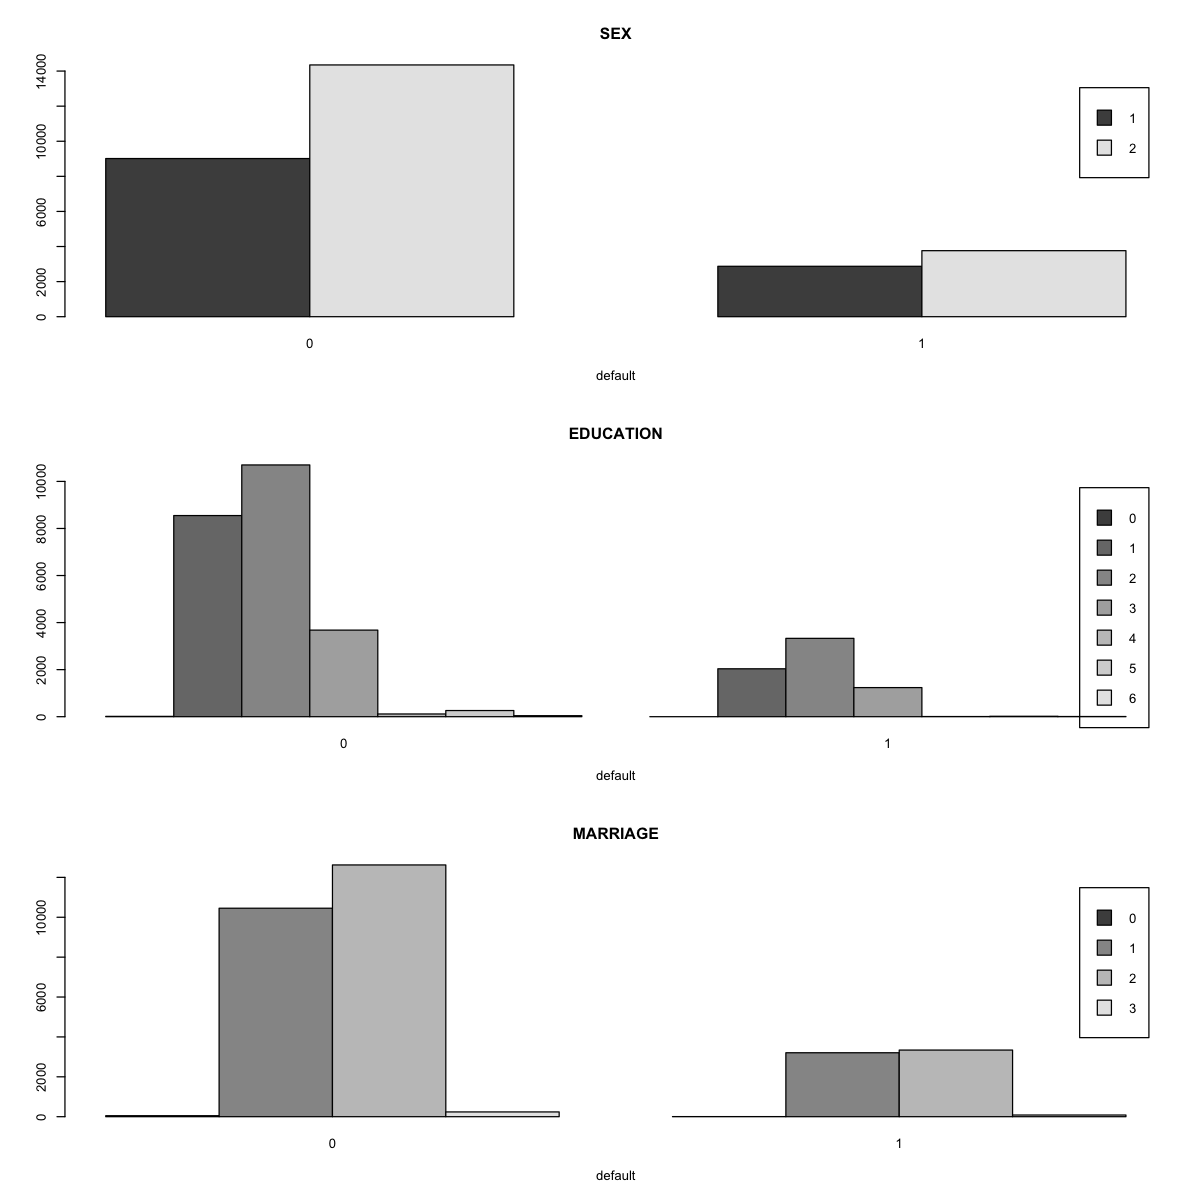

In [64]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(3,1))
crossTab_barplots <- function(featureVector, dataIN, labelCol){
    tab <- table(dataIN[[featureVector]], dataIN[[labelCol]]) 
    barplot(tab, main=featureVector,
    xlab=labelCol,
    legend = rownames(tab), beside=TRUE)
}

sapply(credit.nominalCols, FUN=crossTab_barplots, credit.data, 'default')

# Stratified Sampling: 
-------

#### Standarize the dataset with zero mean and unit variance

In [66]:
credit.data.scaledNumeric <- scale(credit.data[credit.numericCols])

# Check if the mean is 0 and is unit variance
stopifnot(colMeans(credit.data.scaledNumeric) != 0)
stopifnot(round(apply(credit.data.scaledNumeric, 2, sd)) == 1)

credit.data.scaled <- cbind(credit.data[credit.nominalCols], credit.data.scaledNumeric, credit.data['default'])

head(credit.data)
head(credit.data.scaled)

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
20000,2,2,1,24,2,2,-1,-1,-2,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,-1,2,0,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,0,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,0,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,-1,0,-1,0,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,0,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


SEX,EDUCATION,MARRIAGE,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
2,2,1,-1.1367012,-1.2459991,1.79453395,1.7823185,-0.6966518,-0.6665876,-1.5300205,⋯,-0.6724861,-0.6630475,-0.6527133,-0.3419359,-0.2270819,-0.2967963,-0.3080574,-0.3141309,-0.29337717,1
2,2,2,-0.3659744,-1.0290300,-0.87497656,1.7823185,0.1388625,0.1887429,0.2349126,⋯,-0.6216256,-0.6062192,-0.5979564,-0.3419359,-0.2135841,-0.2400006,-0.2442256,-0.3141309,-0.18087519,1
2,2,2,-0.5971924,-0.1611538,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.4497227,-0.4171807,-0.3916230,-0.2502874,-0.1918835,-0.2400006,-0.2442256,-0.2486786,-0.01212223,0
2,2,1,-0.9054832,0.1642998,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.2323688,-0.1867259,-0.1565763,-0.2211869,-0.1693583,-0.2286415,-0.2378424,-0.2441624,-0.23712618,0
1,2,1,-0.9054832,2.3339904,-0.87497656,0.1117342,-0.6966518,0.1887429,0.2349126,⋯,-0.3469914,-0.3481314,-0.3314761,-0.2211869,1.3350119,0.2711608,0.2664292,-0.2690343,-0.25518275,0
1,1,2,-0.9054832,0.1642998,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.3710227,-0.3403515,-0.3164813,-0.1909996,-0.1782122,-0.2594815,-0.2442256,-0.2486786,-0.24837638,0


#### Train and Test for the Scaled dataset:

In [67]:
# Get the Null model and the Full model
credit.dataIN <- credit.data.scaled
credit.null.model <- as.formula(paste('default', "~", 1))
credit.full.model <- bindModel(yLabel = 'default',xFeatures = c(credit.nominalCols, credit.numericCols))

credit.null.model
credit.full.model

# Get the Train Test Data
dataOUT <- stratifiedSampling(dataIN=credit.dataIN, sample_on_col='default', trainPrcnt = 0.8)

credit.trainData <- dataOUT[[1]]
credit.testData <- dataOUT[[2]]
nrow(credit.trainData)
nrow(credit.testData)
head(credit.trainData)

default ~ 1

default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + 
    BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6 + PAY_AMT1 + 
    PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6
<environment: 0x7ff4e4049318>

[1] 24000

[1] 6000

SEX,EDUCATION,MARRIAGE,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
2,2,1,-1.1367012,-1.2459991,1.79453395,1.7823185,-0.6966518,-0.6665876,-1.5300205,⋯,-0.6724861,-0.6630475,-0.6527133,-0.3419359,-0.2270819,-0.2967963,-0.3080574,-0.3141309,-0.29337717,1
2,2,2,-0.3659744,-1.0290300,-0.87497656,1.7823185,0.1388625,0.1887429,0.2349126,⋯,-0.6216256,-0.6062192,-0.5979564,-0.3419359,-0.2135841,-0.2400006,-0.2442256,-0.3141309,-0.18087519,1
2,2,2,-0.5971924,-0.1611538,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.4497227,-0.4171807,-0.3916230,-0.2502874,-0.1918835,-0.2400006,-0.2442256,-0.2486786,-0.01212223,0
2,2,1,-0.9054832,0.1642998,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.2323688,-0.1867259,-0.1565763,-0.2211869,-0.1693583,-0.2286415,-0.2378424,-0.2441624,-0.23712618,0
1,2,1,-0.9054832,2.3339904,-0.87497656,0.1117342,-0.6966518,0.1887429,0.2349126,⋯,-0.3469914,-0.3481314,-0.3314761,-0.2211869,1.3350119,0.2711608,0.2664292,-0.2690343,-0.25518275,0
1,1,2,-0.9054832,0.1642998,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.3710227,-0.3403515,-0.3164813,-0.1909996,-0.1782122,-0.2594815,-0.2442256,-0.2486786,-0.24837638,0


#### Train and Test for the Dummy variable:

In [68]:
credit.data.dummy <- factorToDummy_DF_Builder(dataFrameIN = credit.data.scaled, 
                                              numericCols = credit.numericCols, 
                                              factorCols = credit.nominalCols,
                                              labelCol = credit.labelCol)

# credit.data.dummy
dataOUT <- stratifiedSampling(dataIN = credit.data.dummy, sample_on_col = credit.labelCol, trainPrcnt = 0.8)
credit.trainData.dummy <- dataOUT[[1]]
credit.testData.dummy  <- dataOUT[[2]]

nrow(credit.trainData.dummy)
nrow(credit.testData.dummy)
head(credit.testData.dummy)

[1] 24000

[1] 6000

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,⋯,EDUCATION1,EDUCATION2,EDUCATION3,EDUCATION4,EDUCATION5,EDUCATION6,MARRIAGE1,MARRIAGE2,MARRIAGE3,default
2,-0.3659744,-1.0290300,-0.87497656,1.7823185,0.1388625,0.1887429,0.2349126,1.9922823,-0.659207763,-0.6667355,⋯,0,1,0,0,0,0,0,1,0,1
14,-0.7513378,-0.5950919,0.90469711,1.7823185,1.8098911,0.1887429,0.2349126,1.9922823,0.197983279,0.2555706,⋯,0,1,0,0,0,0,0,1,0,1
16,-0.9054832,-1.3544836,0.90469711,1.7823185,0.1388625,0.1887429,0.2349126,0.2531332,-0.008274921,-0.2810878,⋯,0,0,1,0,0,0,0,0,1,0
21,-0.2889017,0.3812689,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,-0.6164414,-0.174715564,-0.3019522,⋯,0,0,1,0,0,0,0,1,0,0
41,1.4837699,-0.2696383,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,0.2531332,2.273955486,2.4182635,⋯,1,0,0,0,0,0,0,1,0,0
59,0.2506070,-0.1611538,-0.87497656,2.6176106,1.8098911,1.8994041,1.9998457,1.9922823,-0.674078235,-0.6755449,⋯,1,0,0,0,0,0,0,1,0,0


###  v. Build a logistic regression model to determine whether or not a customer defaulted. Use all of the variables. Validate the model on a test data set. Use the comments to discuss the performance of the model.

Findings: We see that the model is not a very good model as the highest accuracy (at threshold 0.43) we observe is about 79% and at that threshold the specificity and sensitivity of finding credit default is very less. For our model we would be interested in catching as many credit default as possible. I feel that at threshold 0.26 the both sensitivity and specificity are about 52% and the accuracy is about 77%

In [69]:
# Fit The Null Model
credit.glm.null <- glm(formula=credit.null.model, family=binomial(logit), data=credit.trainData)
summary(credit.glm.null)

# Fit The Full Model
credit.glm.full <- glm(formula=credit.full.model, family=binomial(logit), data=credit.trainData)
summary(credit.glm.full)

# Predict for the Full model
credit.testData$defaultPred <- predict(credit.glm.full, newdata=credit.testData, type="response")


Call:
glm(formula = credit.null.model, family = binomial(logit), data = credit.trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7072  -0.7072  -0.7072  -0.7072   1.7369  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.25840    0.01555  -80.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25367  on 23999  degrees of freedom
Residual deviance: 25367  on 23999  degrees of freedom
AIC: 25369

Number of Fisher Scoring iterations: 4



Call:
glm(formula = credit.full.model, family = binomial(logit), data = credit.trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1466  -0.7016  -0.5417  -0.2879   3.8554  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.965473  82.362968  -0.157 0.874915    
SEX2         -0.115560   0.034374  -3.362 0.000774 ***
EDUCATION1   10.852732  82.361470   0.132 0.895167    
EDUCATION2   10.741100  82.361470   0.130 0.896239    
EDUCATION3   10.740502  82.361476   0.130 0.896245    
EDUCATION4    9.958414  82.362431   0.121 0.903763    
EDUCATION5    9.371418  82.362021   0.114 0.909410    
EDUCATION6   10.495143  82.362758   0.127 0.898603    
MARRIAGE1     0.894802   0.497231   1.800 0.071928 .  
MARRIAGE2     0.723319   0.497493   1.454 0.145966    
MARRIAGE3     0.939287   0.518803   1.810 0.070220 .  
LIMIT_BAL    -0.100094   0.022834  -4.384 1.17e-05 ***
AGE           0.067824   0.019185   3.535 0.000407 ***
PAY_0     

In [75]:
head(credit.testData)

,SEX,EDUCATION,MARRIAGE,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,defaultPred
7,1,1,2,2.56278744,-0.7035764,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,7.2814525,7.3054951,2.9786623,1.47906029,1.86144092,0.9838354,0.5858380,0.48119893,0,0.05459963
17,1,1,2,-1.13670120,-1.2459991,0.01486028,0.1117342,1.8098911,1.8994041,1.9998457,⋯,-0.3685436,-0.3319294,-0.1487375,-0.25698524,-0.21160275,-0.3080574,-0.2061346,-0.29337717,1,0.30281372
20,2,1,2,0.09646168,-0.7035764,0.90469711,-1.5588500,-1.5321662,-1.5219182,-1.5300205,⋯,-0.6630475,-0.6527133,-0.3419359,-0.25698524,-0.29679633,-0.3080574,-0.3141309,-0.29337717,0,0.25553872
30,1,1,2,-0.90548316,-1.0290300,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,-0.3608129,-0.4612908,-0.2513741,-0.19188353,-0.24000061,-0.2442256,-0.2094072,-0.29337717,0,0.24693987
36,1,1,2,-0.05768368,-0.5950919,-0.87497656,-0.7235579,-1.5321662,-1.5219182,-1.5300205,⋯,-0.6875223,-0.6843484,-0.3340269,-0.23979838,-0.27430522,-0.2719924,-0.2622927,-0.29337717,0,0.09463263
41,1,1,2,1.48376992,-0.2696383,0.01486028,0.1117342,0.1388625,0.1887429,0.2349126,⋯,2.5602776,2.3567180,0.2618092,0.04682273,0.04397797,11.7459496,1.5185331,-0.06837322,0,0.02516026


--> Evaluation Metrics: (accuracy/ specificity and sensitivity)

accuracy,specificity,sensitivity
0.2236667,0.2213115,0.9977376
0.2240000,0.2213855,0.9977376
0.2240000,0.2212923,0.9969834
0.2240000,0.2210121,0.9947210
0.2246667,0.2211603,0.9947210
0.2251667,0.2212716,0.9947210


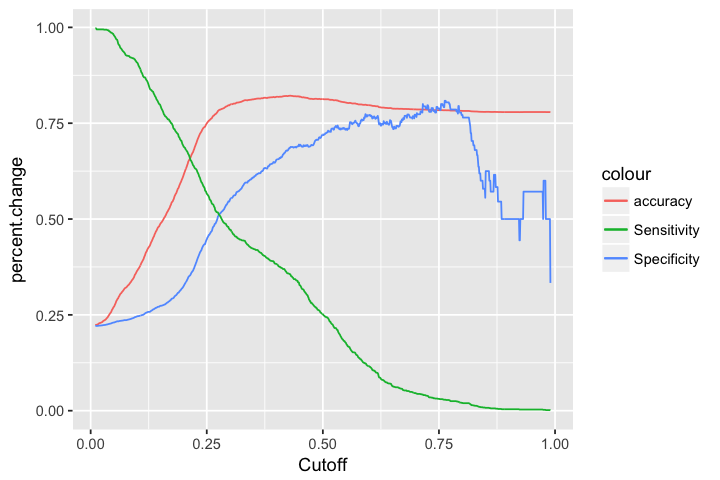

In [76]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange, credit.testData$default, credit.testData$defaultPred)
perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'specificity', 'sensitivity')
head(perfDF)

# Plot Accuracy, Specificity and Sensitivity
options(repr.plot.width=6, repr.plot.height=4)
p <- ggplot() + 
  geom_line(data = perfDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = specificity, color = "Specificity")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = sensitivity, color = "Sensitivity")) +
  xlab('Cutoff') +
  ylab('percent.change')
p

### vi. Using forward selection, determine the best model.

Finding: The best model using forward selection is: 

default ~ PAY_0 + LIMIT_BAL + PAY_3 + PAY_AMT1 + BILL_AMT1 + 
    AGE + EDUCATION + BILL_AMT2 + MARRIAGE + PAY_AMT2 + PAY_5 + 
    SEX + PAY_AMT5 + PAY_2 + BILL_AMT3 + PAY_AMT4
    
The prediction using the full model and the best model using the forward selection technique are pretty close, thats the reason we dont see any improvement in the performance metric using the forward selected best model.

In [77]:
credit.glm.forward = step(credit.glm.null,scope=list(lower=credit.null.model,upper=formula(credit.full.model)), direction="forward")
credit.glm.fowardbestModel <- formula(credit.glm.forward)

credit.glm.full.forward <- glm(formula=credit.glm.fowardbestModel, family=binomial(logit), data=credit.trainData)

Start:  AIC=25369.3
default ~ 1



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
+ PAY_0      1    22823 22827
+ PAY_2      1    23806 23810
+ PAY_3      1    24103 24107
+ PAY_4      1    24295 24299
+ PAY_5      1    24415 24419
+ PAY_6      1    24585 24589
+ LIMIT_BAL  1    24751 24755
+ PAY_AMT1   1    25095 25099
+ PAY_AMT2   1    25135 25139
+ EDUCATION  6    25220 25234
+ PAY_AMT5   1    25234 25238
+ PAY_AMT3   1    25241 25245
+ PAY_AMT4   1    25254 25258
+ PAY_AMT6   1    25281 25285
+ SEX        1    25326 25330
+ MARRIAGE   3    25333 25341
+ BILL_AMT1  1    25355 25359
+ AGE        1    25358 25362
+ BILL_AMT2  1    25361 25365
+ BILL_AMT3  1    25361 25365
+ BILL_AMT4  1    25364 25368
<none>            25367 25369
+ BILL_AMT6  1    25366 25370
+ BILL_AMT5  1    25366 25370

Step:  AIC=22827.26
default ~ PAY_0



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
+ LIMIT_BAL  1    22660 22666
+ BILL_AMT1  1    22702 22708
+ PAY_AMT1   1    22708 22714
+ PAY_3      1    22712 22718
+ BILL_AMT2  1    22718 22724
+ BILL_AMT3  1    22726 22732
+ PAY_AMT2   1    22727 22733
+ PAY_2      1    22736 22742
+ BILL_AMT4  1    22737 22743
+ PAY_4      1    22742 22748
+ BILL_AMT5  1    22751 22757
+ BILL_AMT6  1    22753 22759
+ PAY_5      1    22753 22759
+ PAY_AMT5   1    22755 22761
+ EDUCATION  6    22761 22777
+ PAY_6      1    22772 22778
+ PAY_AMT4   1    22777 22783
+ PAY_AMT3   1    22778 22784
+ PAY_AMT6   1    22782 22788
+ MARRIAGE   3    22792 22802
+ AGE        1    22802 22808
+ SEX        1    22807 22813
<none>            22823 22827

Step:  AIC=22665.82
default ~ PAY_0 + LIMIT_BAL

            Df Deviance   AIC
+ PAY_3      1    22592 22600
+ PAY_AMT1   1    22597 22605
+ PAY_2      1    22610 22618
+ PAY_AMT2   1    22611 22619
+ PAY_4      1    22612 22620
+ EDUCATION  6    22603 22621
+ BILL_AMT1  1    22

--> Evaluation GLM best Model with Forward Selection: 

accuracy,specificity,sensitivity
0.2233333,0.2213307,0.9984917
0.2233333,0.2213307,0.9984917
0.2241667,0.2215158,0.9984917
0.2245000,0.2215900,0.9984917
0.2248333,0.2216642,0.9984917
0.2250000,0.2214214,0.9962293


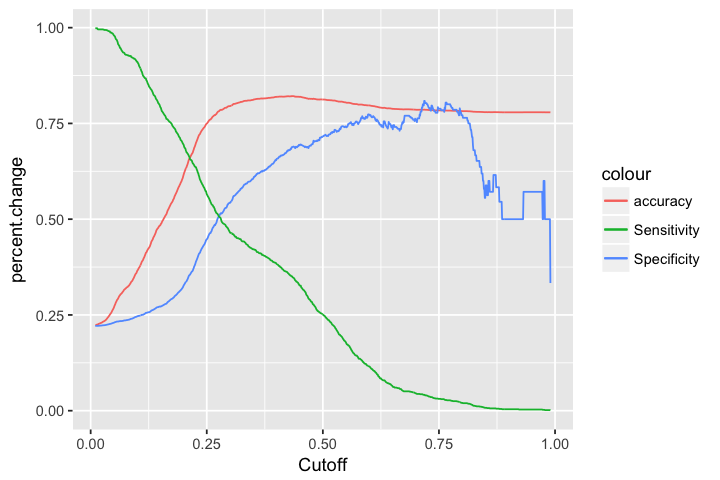

In [84]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange, credit.testData$default, credit.testData$defaultPredForward)
perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'specificity', 'sensitivity')
head(perfDF)

# Plot Accuracy, Specificity and Sensitivity
options(repr.plot.width=6, repr.plot.height=4)
p <- ggplot() + 
  geom_line(data = perfDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = specificity, color = "Specificity")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = sensitivity, color = "Sensitivity")) +
  xlab('Cutoff') +
  ylab('percent.change')
p

### vii.  Using the backwards selection function you implemented in Problem 1 determine the best model.

### viii. Run an implementation of backwards selection found in an R package on this data set. Discuss any differences between the results of this implementation and your implemnetation in question 7.

In [18]:
credit.glm.backward <- step(credit.glm.full)
credit.glm.backwardbestModel <- formula(credit.glm.backward)

credit.glm.full.backward <- glm(formula=credit.glm.backwardbestModel, family=binomial(logit), data=credit.trainData)
summary(credit.glm.full.backward)

# Predict for the Full model
credit.testData$defaultPredBackward <- predict(credit.glm.full.backward, newdata=credit.testData, type="response")

Start:  AIC=22375.12
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + 
    BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6 + PAY_AMT1 + 
    PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- BILL_AMT5  1    22313 22373
- PAY_4      1    22313 22373
- BILL_AMT6  1    22313 22373
- BILL_AMT4  1    22313 22373
- PAY_AMT6   1    22314 22374
- PAY_5      1    22314 22374
- BILL_AMT2  1    22314 22374
- PAY_6      1    22314 22374
<none>            22313 22375
- PAY_AMT3   1    22315 22375
- BILL_AMT3  1    22316 22376
- PAY_AMT4   1    22317 22377
- PAY_AMT5   1    22317 22377
- AGE        1    22318 22378
- PAY_3      1    22321 22381
- SEX        1    22324 22384
- PAY_2      1    22330 22390
- BILL_AMT1  1    22332 22392
- LIMIT_BAL  1    22332 22392
- PAY_AMT2   1    22335 22395
- MARRIAGE   3    22345 22401
- PAY_AMT1   1    22342 22402
- EDUCATION  6    22363 22413
- PAY_0      1    23198 23258

Step:  AIC=22373.14
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + 
    BILL_AMT3 + BILL_AMT4 + BILL_AMT6 + PAY_AMT1 + PAY_AMT2 + 
    PAY_AMT3 + PAY_AMT4 + PAY_A

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- PAY_4      1    22313 22371
- BILL_AMT4  1    22313 22371
- BILL_AMT6  1    22313 22371
- PAY_AMT6   1    22314 22372
- PAY_5      1    22314 22372
- BILL_AMT2  1    22314 22372
- PAY_6      1    22314 22372
<none>            22313 22373
- PAY_AMT3   1    22315 22373
- BILL_AMT3  1    22316 22374
- PAY_AMT4   1    22318 22376
- PAY_AMT5   1    22318 22376
- AGE        1    22318 22376
- PAY_3      1    22321 22379
- SEX        1    22324 22382
- PAY_2      1    22330 22388
- BILL_AMT1  1    22332 22390
- LIMIT_BAL  1    22332 22390
- PAY_AMT2   1    22335 22393
- MARRIAGE   3    22345 22399
- PAY_AMT1   1    22342 22400
- EDUCATION  6    22363 22411
- PAY_0      1    23198 23256

Step:  AIC=22371.16
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + 
    BILL_AMT4 + BILL_AMT6 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + 
    PAY_AMT4 + PAY_AMT5 + PAY_AMT6



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- BILL_AMT4  1    22313 22369
- BILL_AMT6  1    22313 22369
- PAY_AMT6   1    22314 22370
- PAY_5      1    22314 22370
- BILL_AMT2  1    22314 22370
- PAY_6      1    22314 22370
<none>            22313 22371
- PAY_AMT3   1    22316 22372
- BILL_AMT3  1    22316 22372
- PAY_AMT4   1    22318 22374
- PAY_AMT5   1    22318 22374
- AGE        1    22318 22374
- PAY_3      1    22323 22379
- SEX        1    22324 22380
- PAY_2      1    22330 22386
- BILL_AMT1  1    22332 22388
- LIMIT_BAL  1    22332 22388
- PAY_AMT2   1    22335 22391
- MARRIAGE   3    22345 22397
- PAY_AMT1   1    22342 22398
- EDUCATION  6    22363 22409
- PAY_0      1    23201 23257

Step:  AIC=22369.21
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + 
    BILL_AMT6 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + 
    PAY_AMT6



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- BILL_AMT6  1    22313 22367
- PAY_AMT6   1    22314 22368
- PAY_5      1    22314 22368
- BILL_AMT2  1    22314 22368
- PAY_6      1    22314 22368
<none>            22313 22369
- BILL_AMT3  1    22316 22370
- PAY_AMT3   1    22316 22370
- PAY_AMT4   1    22318 22372
- PAY_AMT5   1    22318 22372
- AGE        1    22318 22372
- PAY_3      1    22323 22377
- SEX        1    22324 22378
- PAY_2      1    22330 22384
- BILL_AMT1  1    22332 22386
- LIMIT_BAL  1    22332 22386
- PAY_AMT2   1    22335 22389
- MARRIAGE   3    22345 22395
- PAY_AMT1   1    22342 22396
- EDUCATION  6    22363 22407
- PAY_0      1    23201 23255

Step:  AIC=22367.4
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + 
    PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- PAY_AMT6   1    22314 22366
- PAY_5      1    22314 22366
- BILL_AMT2  1    22314 22366
- PAY_6      1    22314 22366
<none>            22313 22367
- PAY_AMT3   1    22316 22368
- PAY_AMT4   1    22318 22370
- BILL_AMT3  1    22318 22370
- PAY_AMT5   1    22318 22370
- AGE        1    22319 22371
- PAY_3      1    22323 22375
- SEX        1    22324 22376
- PAY_2      1    22330 22382
- LIMIT_BAL  1    22332 22384
- BILL_AMT1  1    22332 22384
- PAY_AMT2   1    22336 22388
- MARRIAGE   3    22345 22393
- PAY_AMT1   1    22343 22395
- EDUCATION  6    22363 22405
- PAY_0      1    23202 23254

Step:  AIC=22365.91
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + 
    PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- PAY_5      1    22315 22365
- BILL_AMT2  1    22315 22365
- PAY_6      1    22315 22365
<none>            22314 22366
- PAY_AMT3   1    22317 22367
- PAY_AMT4   1    22318 22368
- BILL_AMT3  1    22318 22368
- PAY_AMT5   1    22319 22369
- AGE        1    22319 22369
- PAY_3      1    22324 22374
- SEX        1    22324 22374
- PAY_2      1    22330 22380
- BILL_AMT1  1    22333 22383
- LIMIT_BAL  1    22333 22383
- PAY_AMT2   1    22337 22387
- MARRIAGE   3    22346 22392
- PAY_AMT1   1    22344 22394
- EDUCATION  6    22364 22404
- PAY_0      1    23203 23253

Step:  AIC=22364.76
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + 
    PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
- BILL_AMT2  1    22316 22364
<none>            22315 22365
- PAY_AMT3   1    22318 22366
- BILL_AMT3  1    22320 22368
- PAY_AMT4   1    22320 22368
- PAY_AMT5   1    22320 22368
- PAY_6      1    22320 22368
- AGE        1    22320 22368
- SEX        1    22325 22373
- PAY_3      1    22327 22375
- PAY_2      1    22332 22380
- BILL_AMT1  1    22334 22382
- LIMIT_BAL  1    22335 22383
- PAY_AMT2   1    22338 22386
- MARRIAGE   3    22347 22391
- PAY_AMT1   1    22345 22393
- EDUCATION  6    22364 22402
- PAY_0      1    23210 23258

Step:  AIC=22363.68
default ~ SEX + EDUCATION + MARRIAGE + LIMIT_BAL + AGE + PAY_0 + 
    PAY_2 + PAY_3 + PAY_6 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + 
    PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

            Df Deviance   AIC
<none>            22316 22364
- PAY_AMT3   1    22319 22365
- PAY_6      1    22321 22367
- PAY_AMT4   1    22321 22367
- PAY_AMT5   1    22321 22367
- AGE        1    22321 22367
- SEX        1    22326 22372
- PAY_3      1    22328 22374
- BILL_AMT3  1    22329 22375
- PAY_2      1    22333 22379
- LIMIT_BAL  1    22336 22382
- MARRIAGE   3    22348 22390
- BILL_AMT1  1    22346 22392
- PAY_AMT2   1    22348 22394
- PAY_AMT1   1    22349 22395
- EDUCATION  6    22365 22401
- PAY_0      1    23212 23258



Call:
glm(formula = credit.glm.backwardbestModel, family = binomial(logit), 
    data = credit.trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1561  -0.7034  -0.5441  -0.2836   3.4641  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -13.77018   89.38918  -0.154 0.877572    
SEX2         -0.11113    0.03427  -3.242 0.001185 ** 
EDUCATION1   10.78620   89.38665   0.121 0.903953    
EDUCATION2   10.71865   89.38665   0.120 0.904552    
EDUCATION3   10.68144   89.38666   0.119 0.904882    
EDUCATION4    9.57944   89.38787   0.107 0.914656    
EDUCATION5    9.40824   89.38708   0.105 0.916175    
EDUCATION6   10.21572   89.38802   0.114 0.909012    
MARRIAGE1     1.75712    0.67285   2.611 0.009015 ** 
MARRIAGE2     1.57396    0.67301   2.339 0.019352 *  
MARRIAGE3     1.64743    0.68902   2.391 0.016805 *  
LIMIT_BAL    -0.10060    0.02271  -4.431 9.40e-06 ***
AGE           0.04428    0.01914   2.314 0.020675 *  
PAY_0   

--> Evalution GLM best model with Backward Elimination 

accuracy,specificity,sensitivity
0.2183333,0.2154567,1
0.2188333,0.2155649,1
0.2195000,0.2157093,1
0.2200000,0.2158177,1
0.2206667,0.2159624,1
0.2215000,0.2161436,1


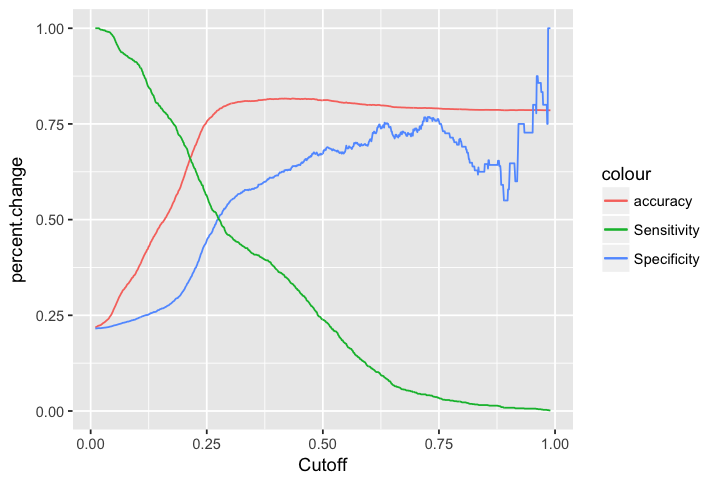

In [19]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange, credit.testData$default, credit.testData$defaultPredBackward)
perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'specificity', 'sensitivity')
head(perfDF)

# Plot Accuracy, Specificity and Sensitivity
options(repr.plot.width=6, repr.plot.height=4)
p <- ggplot() + 
  geom_line(data = perfDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = specificity, color = "Specificity")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = sensitivity, color = "Sensitivity")) +
  xlab('Cutoff') +
  ylab('percent.change')
p

### ix. Run lasso regression on the data set. Briefly discuss how you determined the appropriate tuning parameters.

In [21]:
# Split the label from the Train and Test Data
xTrainData <- credit.trainData.dummy[, -which(names(credit.trainData.dummy) == credit.labelCol)]
yTrainLabel <- credit.trainData.dummy[credit.labelCol]
xTestData <- credit.testData.dummy[, -which(names(credit.testData.dummy) == credit.labelCol)]
yTestLabel <- credit.testData.dummy[credit.labelCol]

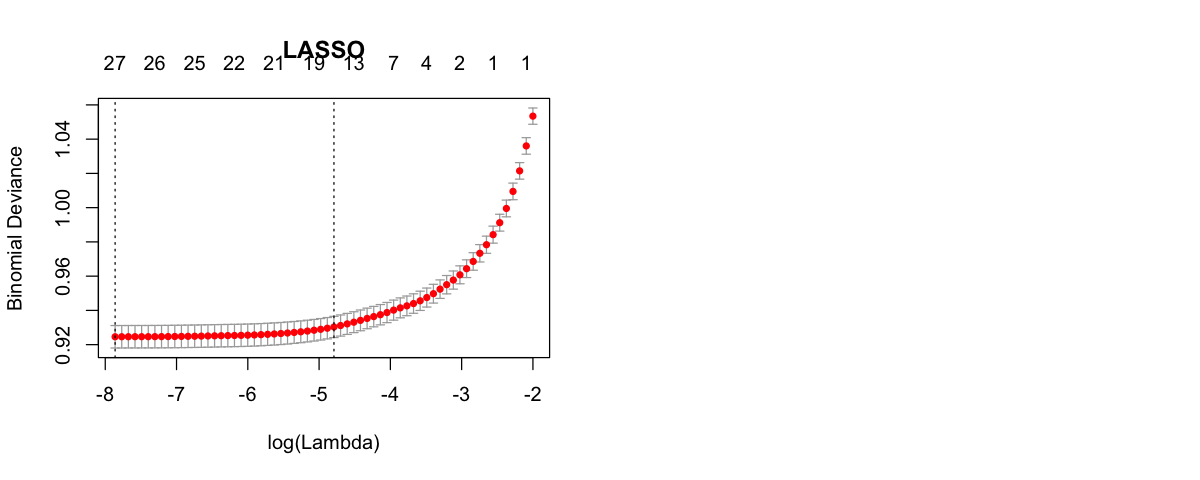

In [22]:
credit.lasso.cv = cv.glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=1, family='binomial')
credit.lasso.predict <- predict(credit.lasso.cv, newx = as.matrix(xTestData), s = "lambda.min", type = "response")
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2))
plot(credit.lasso.cv, main="LASSO")

accuracy,specificity,sensitivity
0.2285000,0.2262004,0.9970501
0.2286667,0.2260549,0.9955752
0.2298333,0.2263202,0.9955752
0.2301667,0.2263961,0.9955752
0.2303333,0.2264341,0.9955752
0.2306667,0.2265101,0.9955752


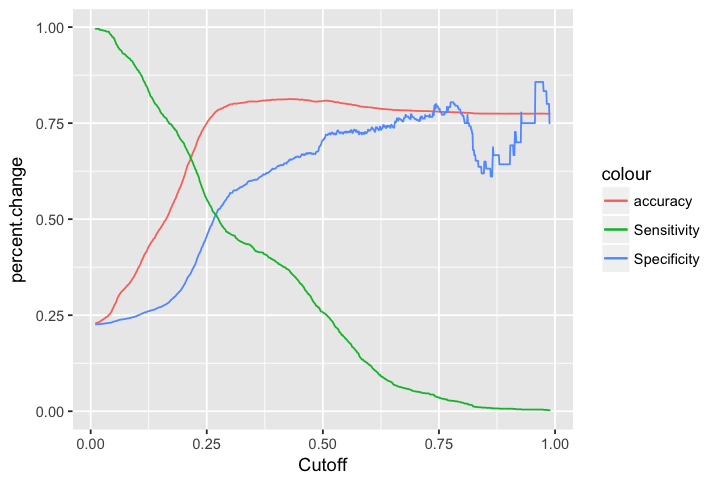

In [24]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange = cutoffRange, 
                                y = yTestLabel$default, 
                                y_hat = unlist(credit.lasso.predict))

perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'specificity', 'sensitivity')
head(perfDF)

# Plot Accuracy, Specificity and Sensitivity
options(repr.plot.width=6, repr.plot.height=4)
p <- ggplot() + 
  geom_line(data = perfDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = specificity, color = "Specificity")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = sensitivity, color = "Sensitivity")) +
  xlab('Cutoff') +
  ylab('percent.change')
p

### x. Run ridge regression on the data set. Briefly discuss how you determined the appropriate tuning parameters.

In [ ]:
credit.ridge.full <- lm.ridge(formula=credit.full.model, data=credit.data.scaled, lambda = seq(0,1,10))

In [ ]:
select(credit.ridge.full)

--> Ridge Regression using GLMNET

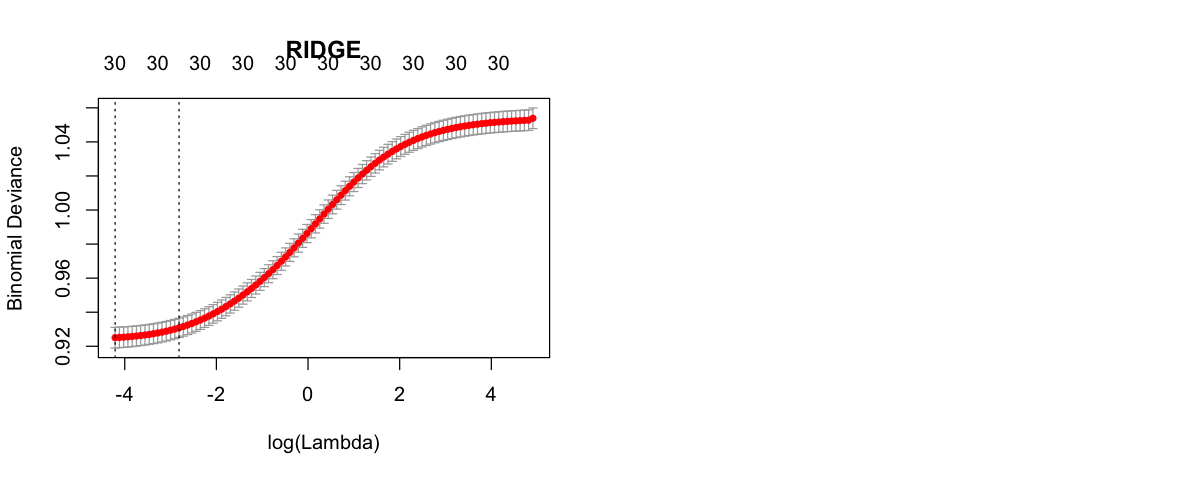

In [26]:
# Here we use glmnet package to do ridge regression
# Find the best lambda and predict on that lambda for the test set.
credit.ridge.cv <- cv.glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=0, family='binomial')
lambdaBest <- credit.ridge.cv$lambda.min
credit.ridge.fit <- glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=0, lambda=credit.ridge.cv$lambda.min, family='binomial')
credit.ridge.predict <- predict(credit.ridge.fit, newx = as.matrix(xTestData), s = lambdaBest, type = "response") 

options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2))
plot(credit.ridge.cv, main="RIDGE")

accuracy,specificity,sensitivity
0.2278333,0.2262322,0.9985251
0.2280000,0.2262701,0.9985251
0.2280000,0.2261785,0.9977876
0.2281667,0.2262164,0.9977876
0.2285000,0.2262004,0.9970501
0.2288333,0.2262762,0.9970501


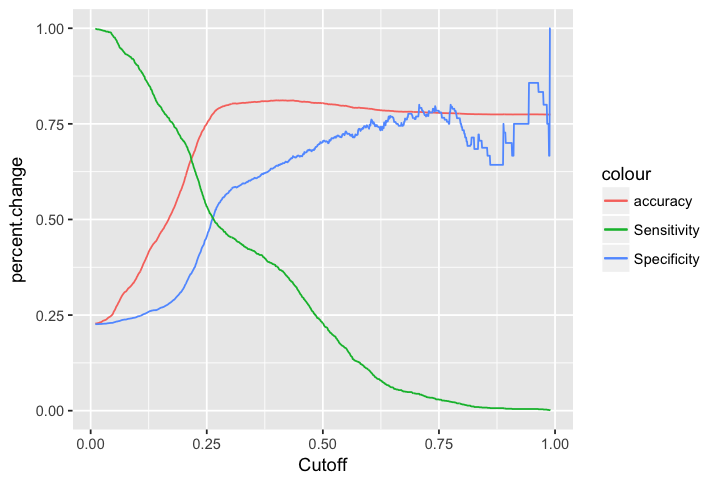

In [27]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange = cutoffRange, 
                                y = yTestLabel$default, 
                                y_hat = unlist(credit.ridge.predict))

perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'specificity', 'sensitivity')
head(perfDF)

# Plot Accuracy, Specificity and Sensitivity
options(repr.plot.width=6, repr.plot.height=4)
p <- ggplot() + 
  geom_line(data = perfDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = specificity, color = "Specificity")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = sensitivity, color = "Sensitivity")) +
  xlab('Cutoff') +
  ylab('percent.change')
p

### xi. Run naive bayes on the data set.

In [56]:
# credit.full.model
credit.nb.fit <- naiveBayes(credit.full.model, data = credit.trainData)
credit.nb.predict <- predict(credit.nb.fit, newdata = credit.testData, type = 'raw')  

In [71]:
preds <- (credit.nb.predict[,'0'] <= credit.nb.predict[,'1'])*1
conf_matrix <- table(preds, yTestLabel$default)
confusionMatrix(conf_matrix)

Confusion Matrix and Statistics

     
preds    0    1
    0 3167  920
    1 1477  436
                                         
               Accuracy : 0.6005         
                 95% CI : (0.588, 0.6129)
    No Information Rate : 0.774          
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.003          
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6820         
            Specificity : 0.3215         
         Pos Pred Value : 0.7749         
         Neg Pred Value : 0.2279         
             Prevalence : 0.7740         
         Detection Rate : 0.5278         
   Detection Prevalence : 0.6812         
      Balanced Accuracy : 0.5017         
                                         
       'Positive' Class : 0              
                                         

accuracy,specificity,sensitivity
0.2865000,0.2273998,0.8997050
0.2876667,0.2274935,0.8982301
0.2885000,0.2277061,0.8982301
0.2893333,0.2277154,0.8967552
0.2896667,0.2276987,0.8960177
0.2906667,0.2277507,0.8945428


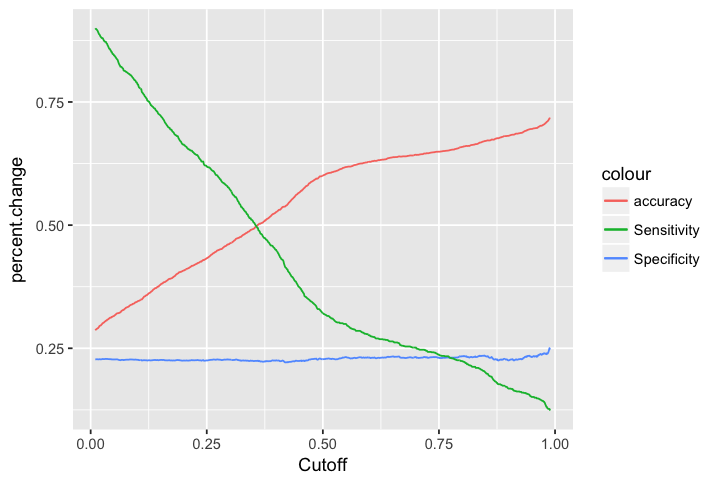

In [73]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange = cutoffRange, 
                                y = yTestLabel$default, 
                                y_hat = credit.nb.predict[,2])

perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'specificity', 'sensitivity')
head(perfDF)

# Plot Accuracy, Specificity and Sensitivity
options(repr.plot.width=6, repr.plot.height=4)
p <- ggplot() + 
  geom_line(data = perfDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = specificity, color = "Specificity")) +
  geom_line(data = perfDF, aes(x = cutoffRange, y = sensitivity, color = "Sensitivity")) +
  xlab('Cutoff') +
  ylab('percent.change')
p

### Build a decision tree to classify the customers as defaulted or not-defaulted. Plot the resulting tree. Discuss whether you feel this is a good model.

In [78]:
credit.dt.fit <- rpart(credit.full.model, data=credit.trainData, method="class")
# credit.dt.predict <- 

In [79]:
summary(credit.dt.fit)

Call:
rpart(formula = credit.full.model, data = credit.trainData, method = "class")
  n= 24000 

         CP nsplit rel error    xerror       xstd
1 0.1914734      0 1.0000000 1.0000000 0.01205484
2 0.0100000      1 0.8085266 0.8085266 0.01113305

Variable importance
PAY_0 PAY_5 PAY_4 PAY_6 PAY_3 PAY_2 
   87     4     3     3     2     1 

Node number 1: 24000 observations,    complexity param=0.1914734
  predicted class=0  expected loss=0.2228333  P(node) =1
    class counts: 18652  5348
   probabilities: 0.777 0.223 
  left son=2 (21470 obs) right son=3 (2530 obs)
  Primary splits:
      PAY_0 < 1.349616  to the left,  improve=1300.6970, (0 missing)
      PAY_2 < 1.364672  to the left,  improve= 976.1443, (0 missing)
      PAY_3 < 1.392134  to the left,  improve= 715.0786, (0 missing)
      PAY_4 < 0.6164082 to the left,  improve= 623.6032, (0 missing)
      PAY_5 < 1.117379  to the left,  improve= 598.0317, (0 missing)
  Surrogate splits:
      PAY_5 < 2.441079  to the left,  agree